# Adaptation of score matching sampler

This notebook is an adaptation of the code in https://github.com/jeremyhengjm/DiffusionBridge/blob/master/repeat_ou.ipynb which I strongly suggest a viewer to look at further.

The purpose of this adaptation is to make it easier to reproduce the speciic results concerning goodness-of-fit tests for infinite dimensional data. 

Both SDE specifications are outlined in the code below, simply uncomment which one you need and set the terminal time T to the desired value. 

In [1]:
import DiffusionBridge as db
import torch
import matplotlib.pyplot as plt
from DiffusionBridge.utils import normal_logpdf
import numpy as np
plt.style.use('ggplot')

In [6]:
# problem settings
d = 1

# Define the SDE and terminal conditions

# sin difusion
# alpha = torch.tensor(0.7)
# beta = torch.tensor(np.pi)
# f = lambda t,x: alpha * torch.sin(x)
# X0 = -np.pi * torch.ones(d)
# XT = 3 * np.pi * torch.ones(d)

# OU difusion
alpha = torch.tensor(-5.0)
beta = torch.tensor(-1.0)
f = lambda t,x: alpha + beta * x 
X0 = -1.0 * torch.ones(d)
XT = 2.0 * torch.ones(d)

sigma = torch.tensor(1.0)
# Set terminal time
T = torch.tensor(4.0)
# Set discretisation
M = 128
diffusion = db.diffusion.model(f, sigma, d, T, M)

# total number of samples
N = 12_000
# Number of repeats
R = 1
# Number of burn_in samples to emove
burn_in = int(N/10)

In [3]:
# learn backward diffusion bridge process with score matching
epsilon = 1e-3
minibatch = 100
num_iterations = 1000
learning_rate = 0.01
ema_momentum = 0.99
output = diffusion.learn_score_transition(X0, XT, epsilon, minibatch, num_iterations, learning_rate, ema_momentum)
score_transition_net = output['net']

# simulate modified backward diffusion bridge (MBDB) process with approximate score
MBDB = {'ess' : torch.zeros(R), 'logestimate' : torch.zeros(R), 'acceptrate' : torch.zeros(R),'current_traj':torch.zeros((N-burn_in,M+1))}
for r in range(R):
    MBDB['current_traj'] = torch.zeros((N-burn_in,M+1))
    with torch.no_grad():
        output = diffusion.simulate_bridge_backwards(score_transition_net, X0, XT, epsilon, N, modify = True)
        trajectories = output['trajectories']
        log_proposal = output['logdensity']
    log_target = diffusion.law_bridge(trajectories) 
    log_weights = log_target - log_proposal

    # importance sampling
    max_log_weights = torch.max(log_weights)
    weights = torch.exp(log_weights - max_log_weights)
    norm_weights = weights / torch.sum(weights)
    ess = 1.0 / torch.sum(norm_weights**2)
    log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
    MBDB['ess'][r] = ess
    MBDB['logestimate'][r] = log_transition_estimate

    # independent Metropolis-Hastings
    initial = diffusion.simulate_bridge_backwards(score_transition_net, X0, XT, epsilon, 1, modify = True)
    current_trajectory = initial['trajectories']
    current_log_proposal = initial['logdensity'] 
    current_log_target = diffusion.law_bridge(current_trajectory)
    current_log_weight = current_log_target - current_log_proposal
    num_accept = 0
    for n in range(N):
        proposed_trajectory = trajectories[n, :, :]
        proposed_log_weight = log_weights[n]
        log_accept_prob = proposed_log_weight - current_log_weight

        if (torch.log(torch.rand(1)) < log_accept_prob):
            current_trajectory = proposed_trajectory.clone()
            current_log_weight = proposed_log_weight.clone()  
            num_accept += 1
        if n > burn_in-1:
            MBDB['current_traj'][n-burn_in,:] = current_trajectory[:,0]
        
    accept_rate = num_accept / N
    MBDB['acceptrate'][r] = accept_rate

    # print
    print('Repeat: ' + str(r) + 
          ' ESS%: ' + str(float(ess * 100 / N)) + 
          ' log-transition density: ' + str(float(log_transition_estimate)),
          ' Accept rate: ' + str(float(accept_rate)))

Optimization iteration: 1 Loss: 6.465476989746094
Optimization iteration: 50 Loss: 4.839850902557373
Optimization iteration: 100 Loss: 4.646862506866455
Optimization iteration: 150 Loss: 4.411350250244141
Optimization iteration: 200 Loss: 4.4995269775390625
Optimization iteration: 250 Loss: 4.5554351806640625
Optimization iteration: 300 Loss: 4.512281894683838
Optimization iteration: 350 Loss: 4.477095603942871
Optimization iteration: 400 Loss: 4.627138614654541
Optimization iteration: 450 Loss: 4.51338005065918
Optimization iteration: 500 Loss: 4.449084758758545
Optimization iteration: 550 Loss: 4.559804439544678
Optimization iteration: 600 Loss: 4.385371685028076
Optimization iteration: 650 Loss: 4.492175579071045
Optimization iteration: 700 Loss: 4.373793601989746
Optimization iteration: 750 Loss: 4.504091739654541
Optimization iteration: 800 Loss: 4.461769104003906
Optimization iteration: 850 Loss: 4.438014030456543
Optimization iteration: 900 Loss: 4.493167400360107
Optimization i

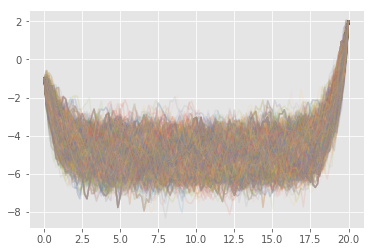

In [4]:
plt.plot(np.linspace(0,T,M+1),MBDB['current_traj'][:2000,:].detach().numpy().T,alpha = 0.1);

In [21]:
np.save('OU_paths/OU_SM_Sample_Quality_Data_T_4.npy',MBDB['current_traj'].numpy().T)